# Insights from Data with BigQuery: Challenge Lab


This notebook is written to document my solutions to the Google Cloud [challenge lab](https://google.qwiklabs.com/focuses/11988?parent=catalog) for the **[Insights from Data with BigQuery](https://google.qwiklabs.com/quests/123)** quest.

You can earn a skill badge after completing the quest and the challenge lab.

[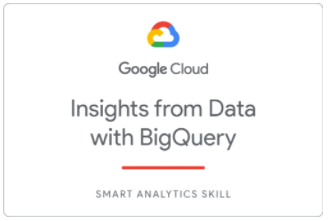](https://google.qwiklabs.com/public_profiles/c0a951c2-747f-4e4a-9520-3a67696131fb)



## Scenario

You're part of a public health organization which is tasked with identifying answers to queries related to the Covid-19 pandemic. Obtaining the right answers will help the organization in planning and focusing healthcare efforts and awareness programs appropriately.


## Dataset

The **COVID-19 Open Data** is available under the **BigQuery Public Datasets Program**. 

The dataset and table that will be used for this analysis will be : `bigquery-public-data.covid19_open_data.covid19_open_data`. This repository contains country-level datasets of daily time-series data related to COVID-19 globally. It includes data relating to demographics, economy, epidemiology, geography, health, hospitalizations, mobility, government response, and weather.

## Query 1: Total Confirmed Cases

Build a query that will answer **"What was the total count of confirmed cases on Apr 15, 2020?"** 

The query needs to return a single row containing the sum of confirmed cases across all countries. The name of the column should be `total_cases_worldwide`.


In [ ]:
SELECT SUM(cumulative_confirmed) AS total_cases_worldwide
FROM bigquery-public-data.covid19_open_data.covid19_open_data
WHERE date = '2020-04-15'

![Q1](Q1.png)

## Query 2: Worst Affected Areas

Build a query for answering **"How many states in the US had more than 100 deaths on Apr 10, 2020?"** 

The query needs to list the output in the field `count_of_states`. 

(Hint: Don't include NULL values)


In [ ]:
WITH US_States AS
(
    SELECT subregion1_name, SUM(cumulative_deceased) AS state_cumulative_deceased
    FROM bigquery-public-data.covid19_open_data.covid19_open_data
    WHERE country_name = "United States of America"
    AND date = '2020-04-10'
    AND subregion1_name IS NOT NULL
    GROUP BY subregion1_name
)

SELECT COUNT(subregion1_name) AS count_of_states
FROM US_States
WHERE state_cumulative_deceased > 100;

![Q2](Q2.png)

## Query 3: Identifying Hotspots

Build a query that will answer **"List all the states in the United States of America that had more than 1000 confirmed cases on Apr 10, 2020?"** 

The query needs to return the State Name and the corresponding confirmed cases arranged in descending order. Name of the fields to return: `state` and `total_confirmed_cases`.

In [ ]:
SELECT subregion1_name AS state,
    SUM(cumulative_confirmed) AS total_confirmed_cases
FROM bigquery-public-data.covid19_open_data.covid19_open_data
WHERE country_code = 'US'
AND date = '2020-04-10'
AND subregion1_name IS NOT NULL
GROUP BY subregion1_name
HAVING total_confirmed_cases > 1000
ORDER BY total_confirmed_cases DESC

![Q3](Q3.png)

## Query 4: Fatality Ratio

Build a query that will answer **"What was the case-fatality ratio in Italy for the month of April 2020?"** 

Case-fatality ratio here is defined as `(total deaths / total confirmed cases) * 100`. 

Write a query to return the ratio for the month of April 2020 and containing the following fields in the output: `total_confirmed_cases`, `total_deaths`, `case_fatality_ratio`.

In [ ]:
SELECT SUM(cumulative_confirmed) AS total_confirmed_cases,
    SUM(cumulative_deceased) AS total_deaths,
    SUM(cumulative_deceased)/SUM(cumulative_confirmed)*100 AS case_fatality_ratio
FROM bigquery-public-data.covid19_open_data.covid19_open_data
WHERE country_name = 'Italy'
AND date BETWEEN '2020-04-01' AND '2020-04-30'

![Q4](Q4.png)

## Query 5: Identifying specific day

Build a query that will answer: **"On what day did the total number of deaths cross 10000 in Italy?"** 

The query should return the date in the format `yyyy-mm-dd`.


In [ ]:
SELECT date
FROM bigquery-public-data.covid19_open_data.covid19_open_data
WHERE country_name = 'Italy'
AND cumulative_deceased > 10000
ORDER BY date
LIMIT 1

![Q5](Q5.png)

## Query 6: Finding days with zero net new cases

The following query is written to identify the number of days in India between 21 Feb 2020 and 15 March 2020 when there were zero increases in the number of confirmed cases. However it is not executing properly. You need to update the query to complete it and obtain the result.


In [ ]:
WITH india_cases_by_date AS (
    SELECT date, SUM(cumulative_confirmed) AS cases
    FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
    WHERE country_name = 'India'
    AND date between '2020-02-21' and '2020-03-15'
    GROUP BY date
    ORDER BY date ASC
), 
    india_previous_day_comparison AS (
    SELECT date, cases,
    LAG(cases) OVER(ORDER BY date) AS previous_day,
    cases - LAG(cases) OVER(ORDER BY date) AS net_new_cases
    FROM india_cases_by_date
)
    
SELECT COUNT(*) FROM india_previous_day_comparison
WHERE net_new_cases = 0  

![Q6](Q6.png)

## Query 7: Doubling rate

Using the previous query as a template, write a query to find out the dates on which the confirmed cases increased by more than 10% compared to the previous day (indicating doubling rate of ~ 7 days) in the US between the dates March 22, 2020 and April 20, 2020. 

The query needs to return the list of dates, the confirmed cases on that day, the confirmed cases the previous day, and the percentage increase in cases between the days. 

Use the following names for the returned fields: `Date`, `Confirmed_Cases_On_Day`, `Confirmed_Cases_Previous_Day` and `Percentage_Increase_In_Cases`.


In [ ]:
WITH US_cases_by_date AS (
    SELECT date, SUM(cumulative_confirmed) AS cases
    FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
    WHERE country_name = 'United States of America'
    AND date BETWEEN '2020-03-22' AND '2020-04-20'
    GROUP BY date
    ORDER BY date ASC
), 
    US_previous_day_comparison AS (
    SELECT date, cases AS Confirmed_Cases_On_Day,
    LAG(cases) OVER(ORDER BY date) AS Confirmed_Cases_Previous_Day,
    (cases - LAG(cases) OVER(ORDER BY date)) / LAG(cases) OVER(ORDER BY date) * 100 AS Percentage_Increase_In_Cases
    FROM US_cases_by_date
)
    
SELECT Date, Confirmed_Cases_On_Day, Confirmed_Cases_Previous_Day, Percentage_Increase_In_Cases
FROM US_previous_day_comparison
WHERE Percentage_Increase_In_Cases > 10 


![Q7](Q7.png)

## Query 8: Recovery rate

Build a query to list the recovery rates of countries arranged in descending order (limit to 10) on the date May 10, 2020. Restrict the query to only those countries having more than 50K confirmed cases. The query needs to return the following fields: `country`, `recovered_cases`, `confirmed_cases`, `recovery_rate`.


In [ ]:
WITH country_cases AS (
    SELECT country_name AS country,
        SUM(cumulative_confirmed) AS confirmed_cases,
        SUM(cumulative_recovered) AS recovered_cases
    FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
    WHERE date = "2020-05-10"
    GROUP BY country_name
),
    country_recovery_rate AS (
    SELECT country, confirmed_cases, recovered_cases,
        (recovered_cases / confirmed_cases * 100) AS recovery_rate
    FROM country_cases
)

SELECT country, confirmed_cases, recovered_cases, recovery_rate
FROM country_recovery_rate
WHERE confirmed_cases > 50000
ORDER BY recovery_rate DESC
LIMIT 10


![Q8](Q8.png)

## Query 9: CDGR - Cumulative Daily Growth Rate

The following query is trying to calculate the CDGR on May 10, 2020 (Cumulative Daily Growth Rate) for France since the day the first case was reported. The first case was reported on Jan 24, 2020. The CDGR is calculated as:
`((last_day_cases/first_day_cases)^1/days_diff)-1)`

Where :

-	`last_day_cases` is the number of confirmed cases on May 10, 2020
-	`first_day_cases` is the number of confirmed cases on Feb 02, 2020
-	`days_diff` is the number of days between Feb 02 - May 10, 2020

The query isn’t executing properly. Fix the error to make the query execute successfully.


In [ ]:
WITH france_cases AS (
    SELECT date, SUM(cumulative_confirmed) AS total_cases
    FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
    WHERE country_name = "France"
    AND date IN ('2020-01-24', '2020-05-10')
    GROUP BY date
    ORDER BY date
), 
    summary AS (
    SELECT total_cases AS first_day_cases,
    LEAD(total_cases) OVER(ORDER BY date) AS last_day_cases,
    DATE_DIFF(LEAD(date) OVER(ORDER BY date),date, day) AS days_diff
    FROM france_cases
    LIMIT 1
)

SELECT first_day_cases, last_day_cases, days_diff, 
    POWER((last_day_cases/first_day_cases), (1/days_diff)) - 1 AS cdgr
FROM summary


![Q9](Q9.png)

## Create a Datastudio report

Create a Datastudio report that plots the following for the United States:
-	Number of Confirmed Cases
-	Number of Deaths
-	Date range : 2020-03-15 to 2020-04-30

Hint: Use the below image as a reference while building the report and make sure your report matches it.

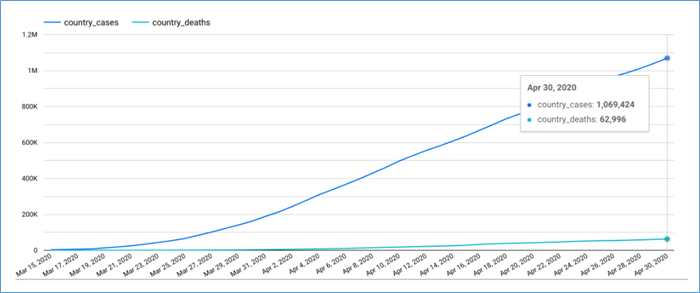


In [ ]:
SELECT date, 
    SUM(cumulative_confirmed) AS country_cases,
    SUM(cumulative_deceased) AS country_deaths
FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE date BETWEEN '2020-03-15' AND '2020-04-30'
    AND country_name = 'United States of America'
GROUP BY date


For this task, run the above query and select **Explore with Data Studio** from the Explore Data dropdown list.

![Q10](Q10.png)

From Data Studio, create a new time series chart.

Add or drag the fields `country_cases` and `country_deaths` into the Metric section.

![Q11](Q11.png)